In [2]:
import pandas as pd
import numpy as np

In [3]:
#Load data and split by city
data = pd.read_csv('merged_with_property.csv', low_memory=False)
data = data.drop(['neighbourhood_group_cleansed', 'neighbourhood', "property_type_original", "host_has_profile_pic"], axis=1)
data = data.dropna(subset=['price_local'])
data_without_na = data.dropna()
dk_data_without_na = data_without_na[data_without_na['city'] == 'Copenhagen'].copy()
no_data_without_na = data_without_na[data_without_na['city'] == 'Oslo'].copy()
dk_data = data[data['city'] == 'Copenhagen'].copy()
no_data = data[data['city'] == 'Oslo'].copy()
print("="*80)
print("MISSING VALUE ANALYSIS BY CITY")
print("="*80)
print(f"\nCopenhagen data: {len(dk_data)} rows")
print(f"Oslo data: {len(no_data)} rows")
print(f"Total: {len(data)} rows")

MISSING VALUE ANALYSIS BY CITY

Copenhagen data: 13831 rows
Oslo data: 8701 rows
Total: 22534 rows


In [4]:
# Calculate missing values for each city
dk_missing = dk_data.isnull().sum()
dk_missing_pct = (dk_missing / len(dk_data) * 100).round(2)

no_missing = no_data.isnull().sum()
no_missing_pct = (no_missing / len(no_data) * 100).round(2)

# Create comparison dataframe
missing_comparison = pd.DataFrame({
    'Copenhagen_Count': dk_missing,
    'Copenhagen_Pct': dk_missing_pct,
    'Oslo_Count': no_missing,
    'Oslo_Pct': no_missing_pct
})

# Only show columns with at least some missing values
missing_comparison = missing_comparison[
    (missing_comparison['Copenhagen_Count'] > 0) | 
    (missing_comparison['Oslo_Count'] > 0)
].sort_values('Copenhagen_Count', ascending=False)

print("\nMissing Values Comparison (Copenhagen vs Oslo):")
print("="*80)
print(missing_comparison.to_string())


Missing Values Comparison (Copenhagen vs Oslo):
                             Copenhagen_Count  Copenhagen_Pct  Oslo_Count  Oslo_Pct
review_scores_location                   2251           16.28        1471     16.91
reviews_per_month                        2250           16.27        1471     16.91
review_scores_value                      2250           16.27        1471     16.91
review_scores_communication              2250           16.27        1471     16.91
review_scores_checkin                    2250           16.27        1471     16.91
review_scores_cleanliness                2250           16.27        1471     16.91
review_scores_accuracy                   2250           16.27        1471     16.91
review_scores_rating                     2250           16.27        1471     16.91
host_response_rate                       1923           13.90        1444     16.60
host_response_time                       1923           13.90        1444     16.60
host_acceptance_rate       

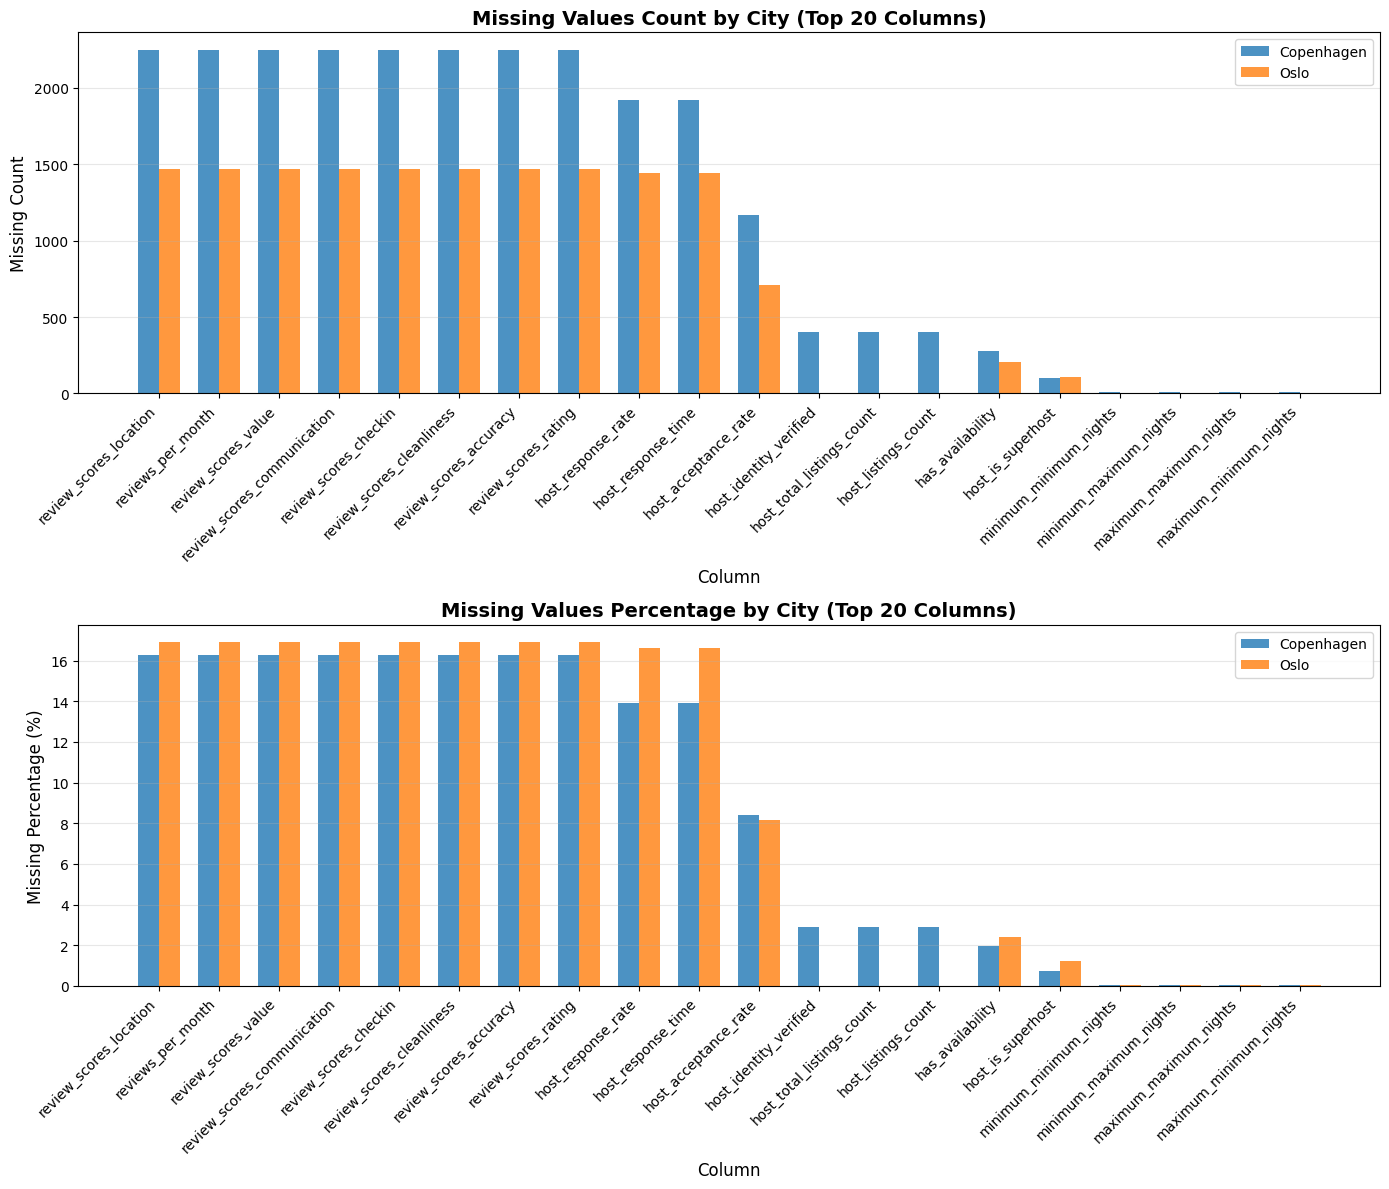

In [5]:
# Visualize missing values comparison
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top plot: Missing counts
top_cols = missing_comparison.head(20).index
x_pos = np.arange(len(top_cols))
width = 0.35

axes[0].bar(x_pos - width/2, missing_comparison.loc[top_cols, 'Copenhagen_Count'], 
            width, label='Copenhagen', alpha=0.8, color='#1f77b4')
axes[0].bar(x_pos + width/2, missing_comparison.loc[top_cols, 'Oslo_Count'], 
            width, label='Oslo', alpha=0.8, color='#ff7f0e')
axes[0].set_xlabel('Column', fontsize=12)
axes[0].set_ylabel('Missing Count', fontsize=12)
axes[0].set_title('Missing Values Count by City (Top 20 Columns)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(top_cols, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Bottom plot: Missing percentages
axes[1].bar(x_pos - width/2, missing_comparison.loc[top_cols, 'Copenhagen_Pct'], 
            width, label='Copenhagen', alpha=0.8, color='#1f77b4')
axes[1].bar(x_pos + width/2, missing_comparison.loc[top_cols, 'Oslo_Pct'], 
            width, label='Oslo', alpha=0.8, color='#ff7f0e')
axes[1].set_xlabel('Column', fontsize=12)
axes[1].set_ylabel('Missing Percentage (%)', fontsize=12)
axes[1].set_title('Missing Values Percentage by City (Top 20 Columns)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(top_cols, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# Imputation Strategy for Review Scores

## Problem Analysis
- Review scores are missing when `number_of_reviews = 0` (structural missingness, MNAR)
- ~16% of listings have missing review scores in both cities
- This is a **Missing Not At Random (MNAR)** pattern

## Recommended Strategy: **Hybrid Approach**
1. **Create indicator variable** `has_reviews` to preserve missingness information
2. **For listings with 0 reviews**: Use model-based imputation (predict from other features)
3. **For listings with reviews but missing specific scores**: Use mean of other review scores for that listing
4. **Fallback**: Use overall mean if other methods fail

This approach:
- ✅ Preserves information about missingness mechanism
- ✅ Uses available data efficiently
- ✅ Theoretically sound for MNAR data
- ✅ Practical and implementable


In [7]:
# ============================================================================
# STEP 1: Identify Review Score Columns
# ============================================================================

print("="*80)
print("STEP 1: Identifying Review Score Columns")
print("="*80)

# Identify all review score columns
review_cols = [col for col in dk_data.columns 
               if 'review_scores' in col.lower()]
review_cols = [col for col in review_cols if col != 'number_of_reviews']  # Exclude count

print(f"\nReview score columns found: {len(review_cols)}")
for col in review_cols:
    print(f"  - {col}")

# Verify the missingness pattern
print("\n" + "="*80)
print("Verifying Missingness Pattern")
print("="*80)

for city_name, city_data in [('Copenhagen', dk_data), ('Oslo', no_data)]:
    print(f"\n{city_name}:")
    zero_reviews = city_data[city_data['number_of_reviews'] == 0]
    has_reviews = city_data[city_data['number_of_reviews'] > 0]
    
    print(f"  Listings with 0 reviews: {len(zero_reviews):,} ({len(zero_reviews)/len(city_data)*100:.1f}%)")
    print(f"  Listings with >0 reviews: {len(has_reviews):,} ({len(has_reviews)/len(city_data)*100:.1f}%)")
    
    if len(zero_reviews) > 0:
        # Check if all review scores are missing for 0-review listings
        missing_all = zero_reviews[review_cols].isnull().all(axis=1).sum()
        print(f"  Listings with 0 reviews missing ALL review scores: {missing_all:,} ({missing_all/len(zero_reviews)*100:.1f}%)")


STEP 1: Identifying Review Score Columns

Review score columns found: 7
  - review_scores_rating
  - review_scores_accuracy
  - review_scores_cleanliness
  - review_scores_checkin
  - review_scores_communication
  - review_scores_location
  - review_scores_value

Verifying Missingness Pattern

Copenhagen:
  Listings with 0 reviews: 2,250 (16.3%)
  Listings with >0 reviews: 11,581 (83.7%)
  Listings with 0 reviews missing ALL review scores: 2,250 (100.0%)

Oslo:
  Listings with 0 reviews: 1,471 (16.9%)
  Listings with >0 reviews: 7,230 (83.1%)
  Listings with 0 reviews missing ALL review scores: 1,471 (100.0%)


In [9]:
# ============================================================================
# STEP 2: Implement Recommended Imputation Strategy
# ============================================================================

print("="*80)
print("STEP 2: Implementing Hybrid Imputation Strategy")
print("="*80)

def impute_review_scores(df, review_cols, use_model_based=True):
    """
    Hybrid imputation strategy for review scores:
    1. Create has_reviews indicator
    2. For listings with 0 reviews: Model-based imputation (or neutral value)
    3. For listings with reviews but missing scores: Mean of other review scores
    4. Fallback: Overall mean
    """
    df_processed = df.copy()
    
    # Step 1: Create indicator variable
    df_processed['has_reviews'] = (df_processed['number_of_reviews'] > 0).astype(int)
    
    # Identify masks
    mask_zero_reviews = df_processed['number_of_reviews'] == 0
    mask_has_reviews = df_processed['number_of_reviews'] > 0
    
    print(f"\nProcessing {len(df_processed):,} listings...")
    print(f"  Listings with 0 reviews: {mask_zero_reviews.sum():,}")
    print(f"  Listings with reviews: {mask_has_reviews.sum():,}")
    
    # Step 2: Handle listings with reviews but missing specific scores
    # Use mean of other review scores for that listing
    for col in review_cols:
        if col not in df_processed.columns:
            continue
        
        # For listings with reviews but missing this specific score
        mask_missing_but_has_reviews = mask_has_reviews & df_processed[col].isna()
        
        if mask_missing_but_has_reviews.sum() > 0:
            # Get other review score columns that exist and are numeric
            other_cols = [c for c in review_cols 
                         if c != col and c in df_processed.columns 
                         and pd.api.types.is_numeric_dtype(df_processed[c])]
            
            if len(other_cols) > 0:
                try:
                    # Calculate mean of other review scores for each row
                    other_scores = df_processed.loc[mask_missing_but_has_reviews, other_cols]
                    
                    # Only calculate mean if we have at least one non-null value per row
                    row_means = other_scores.mean(axis=1, skipna=True)
                    
                    # Fill where we have other scores
                    mask_to_fill = mask_missing_but_has_reviews & row_means.notna()
                    if mask_to_fill.sum() > 0:
                        df_processed.loc[mask_to_fill, col] = row_means[mask_to_fill]
                    
                    # For remaining, use overall mean of this score (from listings with reviews)
                    remaining = mask_missing_but_has_reviews & row_means.isna()
                    if remaining.sum() > 0:
                        overall_mean = df_processed.loc[mask_has_reviews, col].mean()
                        if pd.notna(overall_mean):
                            df_processed.loc[remaining, col] = overall_mean
                            print(f"  {col:40} : Imputed {remaining.sum():>5,} values using overall mean")
                except Exception as e:
                    # If calculation fails, use overall mean
                    overall_mean = df_processed.loc[mask_has_reviews, col].mean()
                    if pd.notna(overall_mean):
                        df_processed.loc[mask_missing_but_has_reviews, col] = overall_mean
                        print(f"  {col:40} : Imputed {mask_missing_but_has_reviews.sum():>5,} values using overall mean (fallback)")
            else:
                # No other columns available, use overall mean
                overall_mean = df_processed.loc[mask_has_reviews, col].mean()
                if pd.notna(overall_mean):
                    df_processed.loc[mask_missing_but_has_reviews, col] = overall_mean
                    print(f"  {col:40} : Imputed {mask_missing_but_has_reviews.sum():>5,} values using overall mean (no other scores)")
    
    # Step 3: Handle listings with 0 reviews
    if mask_zero_reviews.sum() > 0:
        if use_model_based:
            # Model-based imputation using other features
            try:
                from sklearn.ensemble import RandomForestRegressor
                
                # Select features for prediction (exclude review scores and target)
                feature_cols = [col for col in df_processed.select_dtypes(include=[np.number]).columns 
                               if col not in review_cols and col != 'has_reviews' and col != 'number_of_reviews']
                
                # Only use features with <50% missing
                feature_cols = [col for col in feature_cols 
                              if df_processed[col].notna().sum() / len(df_processed) > 0.5]
                
                print(f"\n  Using model-based imputation for 0-review listings...")
                print(f"  Features used: {len(feature_cols)}")
                
                for col in review_cols:
                    if col not in df_processed.columns:
                        continue
                    
                    # Train on listings with reviews
                    train_mask = mask_has_reviews & df_processed[col].notna()
                    
                    if train_mask.sum() > 100 and len(feature_cols) > 0:
                        # Prepare training data
                        X_train = df_processed.loc[train_mask, feature_cols].fillna(
                            df_processed.loc[train_mask, feature_cols].median())
                        y_train = df_processed.loc[train_mask, col]
                        
                        # Prepare test data (0-review listings)
                        X_test = df_processed.loc[mask_zero_reviews, feature_cols].fillna(
                            df_processed.loc[train_mask, feature_cols].median())
                        
                        # Train model
                        model = RandomForestRegressor(
                            n_estimators=50, 
                            max_depth=10,
                            random_state=42, 
                            n_jobs=-1
                        )
                        model.fit(X_train, y_train)
                        
                        # Predict
                        predictions = model.predict(X_test)
                        df_processed.loc[mask_zero_reviews, col] = predictions
                        
                        print(f"    {col:40} : Imputed {len(predictions):>5,} values (RF model)")
                    else:
                        # Fallback: Use overall mean
                        overall_mean = df_processed.loc[mask_has_reviews, col].mean()
                        if pd.notna(overall_mean):
                            df_processed.loc[mask_zero_reviews, col] = overall_mean
                            print(f"    {col:40} : Imputed {mask_zero_reviews.sum():>5,} values (overall mean)")
                
            except Exception as e:
                print(f"  Model-based imputation failed: {e}")
                print("  Falling back to overall mean...")
                use_model_based = False
        
        if not use_model_based:
            # Fallback: Use overall mean for each review score
            print(f"\n  Using overall mean imputation for 0-review listings...")
            for col in review_cols:
                if col not in df_processed.columns:
                    continue
                
                overall_mean = df_processed.loc[mask_has_reviews, col].mean()
                if pd.notna(overall_mean):
                    df_processed.loc[mask_zero_reviews, col] = overall_mean
                    print(f"    {col:40} : Imputed {mask_zero_reviews.sum():>5,} values (mean = {overall_mean:.2f})")
    
    return df_processed

# Apply imputation to both cities
print("\n" + "="*80)
print("Applying to Copenhagen data...")
print("="*80)
dk_imputed = impute_review_scores(dk_data.copy(), review_cols, use_model_based=True)

print("\n" + "="*80)
print("Applying to Oslo data...")
print("="*80)
no_imputed = impute_review_scores(no_data.copy(), review_cols, use_model_based=True)


STEP 2: Implementing Hybrid Imputation Strategy

Applying to Copenhagen data...

Processing 13,831 listings...
  Listings with 0 reviews: 2,250
  Listings with reviews: 11,581

  Using model-based imputation for 0-review listings...
  Features used: 30
    review_scores_rating                     : Imputed 2,250 values (RF model)
    review_scores_accuracy                   : Imputed 2,250 values (RF model)
    review_scores_cleanliness                : Imputed 2,250 values (RF model)
    review_scores_checkin                    : Imputed 2,250 values (RF model)
    review_scores_communication              : Imputed 2,250 values (RF model)
    review_scores_location                   : Imputed 2,250 values (RF model)
    review_scores_value                      : Imputed 2,250 values (RF model)

Applying to Oslo data...

Processing 8,701 listings...
  Listings with 0 reviews: 1,471
  Listings with reviews: 7,230

  Using model-based imputation for 0-review listings...
  Features used: 

In [10]:
# ============================================================================
# STEP 3: Verify Imputation Results
# ============================================================================

print("="*80)
print("STEP 3: Verification of Imputation Results")
print("="*80)

def verify_imputation(original_df, imputed_df, review_cols, city_name):
    """Verify that imputation worked correctly"""
    print(f"\n{city_name}:")
    print("-" * 80)
    
    print("\nBefore imputation:")
    for col in review_cols:
        if col in original_df.columns:
            missing = original_df[col].isna().sum()
            print(f"  {col:40} : {missing:>6,} missing ({missing/len(original_df)*100:>5.2f}%)")
    
    print("\nAfter imputation:")
    for col in review_cols:
        if col in imputed_df.columns:
            missing = imputed_df[col].isna().sum()
            reduction = original_df[col].isna().sum() - missing
            print(f"  {col:40} : {missing:>6,} missing ({missing/len(imputed_df)*100:>5.2f}%) | Reduced by {reduction:>6,}")
    
    # Check statistics
    print("\nImputed value statistics:")
    for col in review_cols:
        if col in imputed_df.columns:
            # Get originally missing values that were imputed
            originally_missing = original_df[col].isna()
            if originally_missing.sum() > 0:
                imputed_values = imputed_df.loc[originally_missing, col]
                if imputed_values.notna().sum() > 0:
                    imputed_clean = imputed_values.dropna()
                    print(f"  {col:40} :")
                    print(f"    Mean: {imputed_clean.mean():.2f}, Std: {imputed_clean.std():.2f}")
                    print(f"    Min: {imputed_clean.min():.2f}, Max: {imputed_clean.max():.2f}")

verify_imputation(dk_data, dk_imputed, review_cols, "Copenhagen")
verify_imputation(no_data, no_imputed, review_cols, "Oslo")


STEP 3: Verification of Imputation Results

Copenhagen:
--------------------------------------------------------------------------------

Before imputation:
  review_scores_rating                     :  2,250 missing (16.27%)
  review_scores_accuracy                   :  2,250 missing (16.27%)
  review_scores_cleanliness                :  2,250 missing (16.27%)
  review_scores_checkin                    :  2,250 missing (16.27%)
  review_scores_communication              :  2,250 missing (16.27%)
  review_scores_location                   :  2,251 missing (16.28%)
  review_scores_value                      :  2,250 missing (16.27%)

After imputation:
  review_scores_rating                     :      0 missing ( 0.00%) | Reduced by  2,250
  review_scores_accuracy                   :      0 missing ( 0.00%) | Reduced by  2,250
  review_scores_cleanliness                :      0 missing ( 0.00%) | Reduced by  2,250
  review_scores_checkin                    :      0 missing ( 0.00%) | Red

STEP 4: Comparing Imputed vs Observed Distributions

Copenhagen - review_scores_rating:
  Observed values: n=11,581, mean=4.84, std=0.27
  Imputed values:  n=2,250, mean=4.77, std=0.21
  KS test: statistic=0.5226, p-value=0.0000
  Distributions differ significantly


/var/folders/n4/yb6rjmrx0zx3n_2_dvfmgzym0000gn/T/ipykernel_33314/2660501747.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_to_plot, labels=['Observed', 'Imputed'])


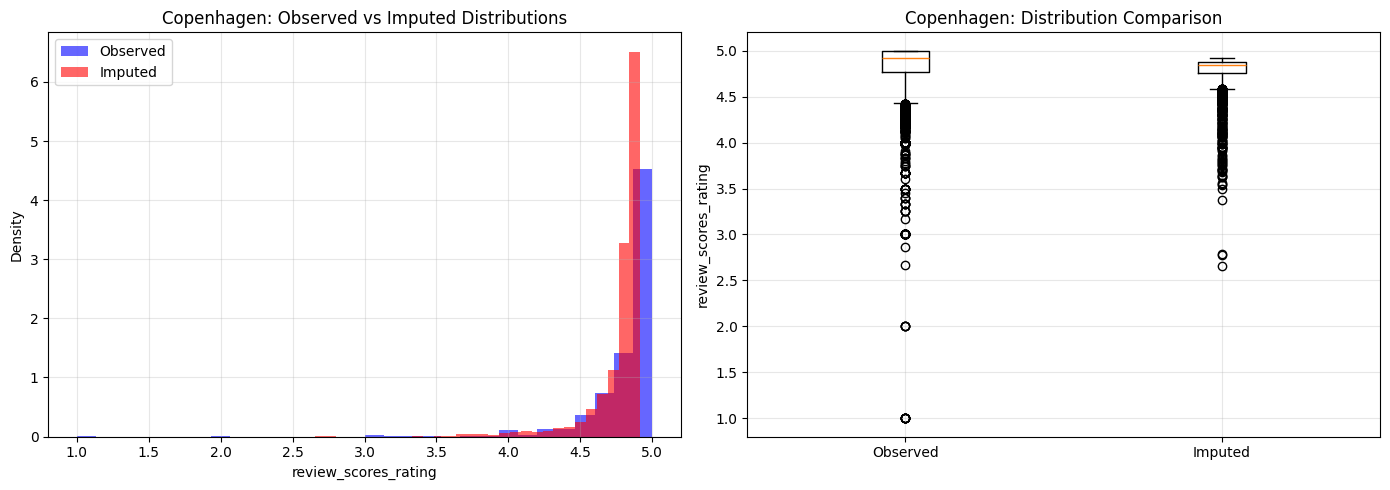


Oslo - review_scores_rating:
  Observed values: n=7,230, mean=4.83, std=0.31
  Imputed values:  n=1,471, mean=4.77, std=0.17
  KS test: statistic=0.5488, p-value=0.0000
  Distributions differ significantly


/var/folders/n4/yb6rjmrx0zx3n_2_dvfmgzym0000gn/T/ipykernel_33314/2660501747.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_to_plot, labels=['Observed', 'Imputed'])


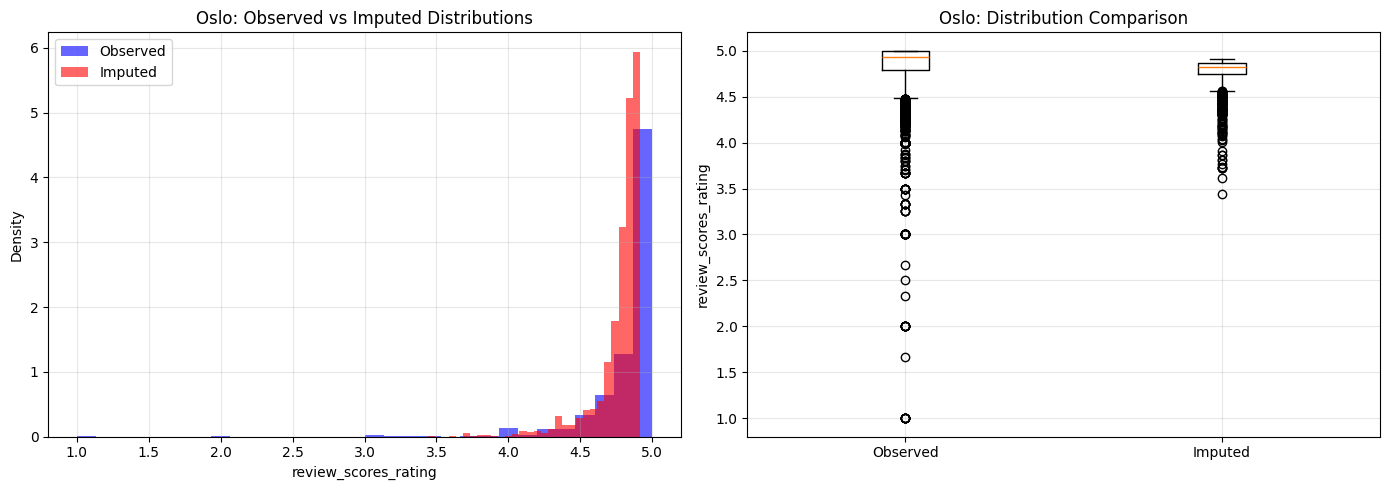

In [11]:
# ============================================================================
# STEP 4: Compare Imputed vs Observed Distributions
# ============================================================================

print("="*80)
print("STEP 4: Comparing Imputed vs Observed Distributions")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns

# Compare distributions for key review score
key_col = 'review_scores_rating'

for city_name, original_df, imputed_df in [('Copenhagen', dk_data, dk_imputed), 
                                            ('Oslo', no_data, no_imputed)]:
    if key_col not in original_df.columns:
        continue
    
    # Get observed values (listings with reviews)
    observed = original_df[original_df['number_of_reviews'] > 0][key_col].dropna()
    
    # Get imputed values (originally missing)
    originally_missing = original_df[key_col].isna()
    imputed = imputed_df.loc[originally_missing, key_col].dropna()
    
    if len(observed) > 0 and len(imputed) > 0:
        print(f"\n{city_name} - {key_col}:")
        print(f"  Observed values: n={len(observed):,}, mean={observed.mean():.2f}, std={observed.std():.2f}")
        print(f"  Imputed values:  n={len(imputed):,}, mean={imputed.mean():.2f}, std={imputed.std():.2f}")
        
        # Statistical test
        try:
            from scipy import stats
            if len(imputed) > 30 and len(observed) > 30:
                ks_stat, p_value = stats.ks_2samp(observed, imputed)
                print(f"  KS test: statistic={ks_stat:.4f}, p-value={p_value:.4f}")
                print(f"  {'Distributions are similar' if p_value > 0.05 else 'Distributions differ significantly'}")
        except:
            pass
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Histogram comparison
        axes[0].hist(observed, bins=30, alpha=0.6, label='Observed', color='blue', density=True)
        axes[0].hist(imputed, bins=30, alpha=0.6, label='Imputed', color='red', density=True)
        axes[0].set_xlabel(key_col)
        axes[0].set_ylabel('Density')
        axes[0].set_title(f'{city_name}: Observed vs Imputed Distributions')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        # Box plot comparison
        data_to_plot = [observed, imputed]
        axes[1].boxplot(data_to_plot, labels=['Observed', 'Imputed'])
        axes[1].set_ylabel(key_col)
        axes[1].set_title(f'{city_name}: Distribution Comparison')
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()


In [12]:
# ============================================================================
# STEP 5: Save Imputed Data
# ============================================================================

print("="*80)
print("STEP 5: Saving Imputed Data")
print("="*80)

# Combine both cities
dk_imputed_final = dk_imputed.copy()
no_imputed_final = no_imputed.copy()

# Save separately or combined
print("\nSaving imputed datasets...")

# Option 1: Save combined
data_imputed = pd.concat([dk_imputed_final, no_imputed_final], ignore_index=True)
data_imputed.to_csv('merged_with_property_imputed.csv', index=False)
print(f"  ✓ Saved combined dataset: merged_with_property_imputed.csv ({len(data_imputed):,} rows)")

# Option 2: Save separately
dk_imputed_final.to_csv('copenhagen_imputed.csv', index=False)
no_imputed_final.to_csv('oslo_imputed.csv', index=False)
print(f"  ✓ Saved Copenhagen dataset: copenhagen_imputed.csv ({len(dk_imputed_final):,} rows)")
print(f"  ✓ Saved Oslo dataset: oslo_imputed.csv ({len(no_imputed_final):,} rows)")

print("\n" + "="*80)
print("IMPUTATION COMPLETE!")
print("="*80)
print("\nSummary:")
print(f"  - Created 'has_reviews' indicator variable")
print(f"  - Imputed all missing review scores")
print(f"  - Preserved information about missingness mechanism")
print(f"  - Used hybrid approach: model-based for 0-review listings,")
print(f"    mean of other scores for listings with partial reviews")
print("\nNext steps:")
print("  - Use 'has_reviews' as a feature in your models")
print("  - Review score columns are now complete (no NaNs)")
print("="*80)


STEP 5: Saving Imputed Data

Saving imputed datasets...
  ✓ Saved combined dataset: merged_with_property_imputed.csv (22,532 rows)
  ✓ Saved Copenhagen dataset: copenhagen_imputed.csv (13,831 rows)
  ✓ Saved Oslo dataset: oslo_imputed.csv (8,701 rows)

IMPUTATION COMPLETE!

Summary:
  - Created 'has_reviews' indicator variable
  - Imputed all missing review scores
  - Preserved information about missingness mechanism
  - Used hybrid approach: model-based for 0-review listings,
    mean of other scores for listings with partial reviews

Next steps:
  - Use 'has_reviews' as a feature in your models
  - Review score columns are now complete (no NaNs)


In [14]:
# ============================================================================
# CHECK FOR REMAINING NaN VALUES IN IMPUTED DATASETS
# ============================================================================

print("="*80)
print("NaN VALUE CHECK IN IMPUTED DATASETS")
print("="*80)

def check_nan_values(df, df_name, review_cols=None):
    """Comprehensive check for NaN values in imputed dataset"""
    print(f"\n{df_name}:")
    print("-" * 80)
    
    # Overall statistics
    total_cells = df.shape[0] * df.shape[1]
    total_nans = df.isnull().sum().sum()
    nan_percentage = (total_nans / total_cells * 100) if total_cells > 0 else 0
    
    print(f"\nOverall Statistics:")
    print(f"  Total rows: {len(df):,}")
    print(f"  Total columns: {len(df.columns):,}")
    print(f"  Total NaN values: {total_nans:,} ({nan_percentage:.2f}% of all cells)")
    
    # Columns with NaN values
    nan_counts = df.isnull().sum()
    columns_with_nans = nan_counts[nan_counts > 0].sort_values(ascending=False)
    
    if len(columns_with_nans) > 0:
        print(f"\nColumns with NaN values ({len(columns_with_nans)} columns):")
        print("-" * 80)
        for col, count in columns_with_nans.items():
            pct = (count / len(df) * 100)
            print(f"  {col:45} : {count:>6,} ({pct:>5.2f}%)")
    else:
        print(f"\n✓ No NaN values found in any column!")
    
    # Focus on review score columns
    if review_cols:
        print(f"\nReview Score Columns Check:")
        print("-" * 80)
        all_review_cols_complete = True
        for col in review_cols:
            if col in df.columns:
                nan_count = df[col].isnull().sum()
                if nan_count > 0:
                    all_review_cols_complete = False
                    pct = (nan_count / len(df) * 100)
                    print(f"  ⚠ {col:45} : {nan_count:>6,} NaN ({pct:>5.2f}%)")
                else:
                    print(f"  ✓ {col:45} : No NaN values")
            else:
                print(f"  ✗ {col:45} : Column not found")
        
        if all_review_cols_complete:
            print(f"\n  ✓ All review score columns are complete (no NaN values)!")
    
    return columns_with_nans

# Check both datasets
print("\n" + "="*80)
dk_nans = check_nan_values(dk_imputed, "Copenhagen (DK) - Imputed Dataset", review_cols)
print("\n" + "="*80)
no_nans = check_nan_values(no_imputed, "Oslo (NO) - Imputed Dataset", review_cols)

# Summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\nCopenhagen:")
print(f"  Columns with NaN: {len(dk_nans)}")
print(f"  Total NaN values: {dk_imputed.isnull().sum().sum():,}")

print(f"\nOslo:")
print(f"  Columns with NaN: {len(no_nans)}")
print(f"  Total NaN values: {no_imputed.isnull().sum().sum():,}")

# Check if review scores are complete
review_cols_complete_dk = all(dk_imputed[col].isnull().sum() == 0 for col in review_cols if col in dk_imputed.columns)
review_cols_complete_no = all(no_imputed[col].isnull().sum() == 0 for col in review_cols if col in no_imputed.columns)

print(f"\nReview Scores Status:")
print(f"  Copenhagen review scores complete: {'✓ YES' if review_cols_complete_dk else '✗ NO'}")
print(f"  Oslo review scores complete: {'✓ YES' if review_cols_complete_no else '✗ NO'}")

print("\n" + "="*80)


NaN VALUE CHECK IN IMPUTED DATASETS


Copenhagen (DK) - Imputed Dataset:
--------------------------------------------------------------------------------

Overall Statistics:
  Total rows: 13,831
  Total columns: 57
  Total NaN values: 8,883 (1.13% of all cells)

Columns with NaN values (17 columns):
--------------------------------------------------------------------------------
  reviews_per_month                             :  2,250 (16.27%)
  host_response_rate                            :  1,923 (13.90%)
  host_response_time                            :  1,923 (13.90%)
  host_acceptance_rate                          :  1,166 ( 8.43%)
  host_listings_count                           :    400 ( 2.89%)
  host_total_listings_count                     :    400 ( 2.89%)
  host_identity_verified                        :    400 ( 2.89%)
  has_availability                              :    275 ( 1.99%)
  host_is_superhost                             :    103 ( 0.74%)
  minimum_minimum_night

In [13]:
dk_data_without_na.to_csv("copenhagen_non_imputed.csv")
no_data_without_na.to_csv("oslo_non_imputed.csv")